In [33]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import matplotlib.pyplot as plt

In [109]:
# Пути к директориям
images_dir_neg25 = r"D:\UAV_obj_det\datasets\rotate_-25\images" 
annotations_dir_neg25 = r"D:\UAV_obj_det\datasets\rotate_-25\labels"  

images_dir_pos25 = r"D:\UAV_obj_det\datasets\rotate_25\images"  
annotations_dir_pos25 = r"D:\UAV_obj_det\datasets\rotate_25\labels"  

In [133]:
model = YOLO(r"D:\UAV_obj_det\runs\detect\yolov11n_20e\weights\best.pt")  

In [135]:
# Функция для расчёта IoU
def calculate_iou(box1, box2):
    # box1 и box2 в формате [x1, y1, x2, y2]
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Пересечение
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    iou = intersection_area / (box1_area + box2_area - intersection_area)
    return iou

In [137]:
# Функция для загрузки аннотаций YOLO
def load_yolo_annotations(txt_path, img_width, img_height):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = list(map(float, line.strip().split()))
            if len(parts) < 5:
                continue  
            class_id, x_center, y_center, w, h = parts
            
            x1 = (x_center - w/2) * img_width
            y1 = (y_center - h/2) * img_height
            x2 = (x_center + w/2) * img_width
            y2 = (y_center + h/2) * img_height
            boxes.append([x1, y1, x2, y2, class_id])
    return boxes

In [139]:
# Функция для расчёта метрик
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0
    ious = []
    used_true_boxes = set()
    
    for pred_box in pred_boxes:
        best_iou = 0
        best_idx = -1
        for i, true_box in enumerate(true_boxes):
            if i in used_true_boxes:
                continue
            iou = calculate_iou(pred_box[:4], true_box[:4])
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        
        if best_iou >= iou_threshold:
            TP += 1
            used_true_boxes.add(best_idx)
            ious.append(best_iou)
        else:
            FP += 1
    
    FN = len(true_boxes) - len(used_true_boxes)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    mean_iou = np.mean(ious) if ious else 0
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "iou": mean_iou,
        "TP": TP,
        "FP": FP,
        "FN": FN
    }

In [141]:
# Обработка изображений и аннотаций
def process_directory(images_dir, annotations_dir, angle_key, metrics_dict):
    for img_name in os.listdir(images_dir):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        
        img_path = os.path.join(images_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img_height, img_width = img.shape[:2]
        
        # Поиск соответствующего файла аннотаций
        base_name = os.path.splitext(img_name)[0]
        txt_path = os.path.join(annotations_dir, f"{base_name}.txt")
        
        true_boxes = load_yolo_annotations(txt_path, img_width, img_height)
        
        # Предсказание модели
        results = model(img_path)
        pred_boxes = []
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            pred_boxes.append([x1, y1, x2, y2, box.cls.item()])
        
        # Расчёт метрик
        metrics_img = calculate_metrics(pred_boxes, true_boxes)
        
        # Сохранение метрик
        for key in metrics_img:
            if key in metrics_dict[angle_key]:
                metrics_dict[angle_key][key].append(metrics_img[key])

In [143]:
# Словарь для хранения метрик
metrics = {
    "-25": {"precision": [], "recall": []},
    "+25": {"precision": [], "recall": []}
}

In [145]:
# Обработка данных для -25°
process_directory(images_dir_neg25, annotations_dir_neg25, "-25", metrics)

# Обработка данных для +25°
process_directory(images_dir_pos25, annotations_dir_pos25, "+25", metrics)


image 1/1 D:\UAV_obj_det\datasets\rotate_-25\images\0_100_30_0_03307_rotated.jpg: 416x512 4 Cars, 107.6ms
Speed: 3.9ms preprocess, 107.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 D:\UAV_obj_det\datasets\rotate_-25\images\0_100_30_0_08074_rotated.jpg: 416x512 4 Cars, 2 Bicycles, 104.2ms
Speed: 2.8ms preprocess, 104.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 D:\UAV_obj_det\datasets\rotate_-25\images\0_100_30_0_08091_rotated.jpg: 416x512 1 Car, 103.4ms
Speed: 2.9ms preprocess, 103.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 D:\UAV_obj_det\datasets\rotate_-25\images\0_100_30_0_08100_rotated.jpg: 416x512 1 Car, 5 Bicycles, 103.7ms
Speed: 2.6ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 D:\UAV_obj_det\datasets\rotate_-25\images\0_100_40_0_03327_rotated.jpg: 416x512 (no detections), 104.5ms
Speed: 2.4ms preprocess, 104.5ms inference

In [146]:
# Вывод средних значений
for angle in ["-25", "+25"]:
    print(f"\nУгол {angle}°:")
    for metric in ["precision", "recall"]:
        values = metrics[angle][metric]
        print(f"{metric}: {np.mean(values):.3f} ± {np.std(values):.3f}")

# Статистический тест
def compare_metrics(metric_name):
    data_neg25 = metrics["-25"][metric_name]
    data_pos25 = metrics["+25"][metric_name]
    
    # Проверка нормальности
    _, p_neg25 = shapiro(data_neg25)
    _, p_pos25 = shapiro(data_pos25)
    
    if p_neg25 > 0.05 and p_pos25 > 0.05:
        t_stat, p_value = ttest_ind(data_neg25, data_pos25)
        test_name = "t-тест"
    else:
        t_stat, p_value = mannwhitneyu(data_neg25, data_pos25)
        test_name = "U-тест"
    
    print(f"\nСравнение {metric_name} ({test_name}):")
    print(f"p-value = {p_value:.5f}")
    if p_value < 0.05:
        print("Различие статистически значимо (p < 0.05)")
    else:
        print("Различие не значимо (p >= 0.05)")

print(f"\nМодель: YOLOv11n")
for metric in ["precision", "recall"]:
    compare_metrics(metric)


Угол -25°:
precision: 0.504 ± 0.328
recall: 0.463 ± 0.331

Угол +25°:
precision: 0.492 ± 0.346
recall: 0.433 ± 0.335

Модель: YOLOv11n

Сравнение precision (U-тест):
p-value = 0.67784
Различие не значимо (p >= 0.05)

Сравнение recall (U-тест):
p-value = 0.11279
Различие не значимо (p >= 0.05)


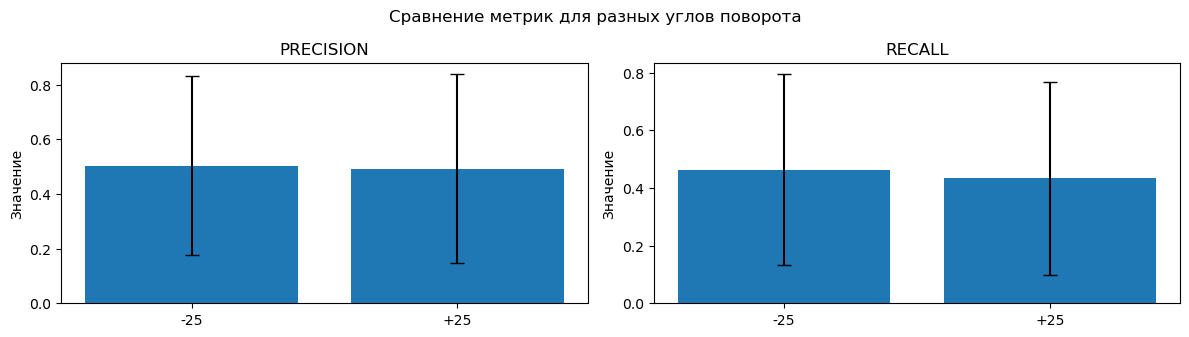

In [147]:
# Визуализация
plt.figure(figsize=(12, 6))
angles = ["-25", "+25"]
for i, metric in enumerate(["precision", "recall"]):
    plt.subplot(2, 2, i+1)
    plt.bar(angles, [np.mean(metrics[angle][metric]) for angle in angles], yerr=[np.std(metrics[angle][metric]) for angle in angles], capsize=5)
    plt.title(metric.upper())
    plt.ylabel("Значение")
plt.suptitle("Сравнение метрик для разных углов поворота")
plt.tight_layout()
plt.savefig("rotation_metrics_comparison.png")
plt.show()